In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
from sklearn import datasets

In [2]:
digits = datasets.load_digits()
print(digits.images.shape)
print(digits.keys())

(1797, 8, 8)
dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


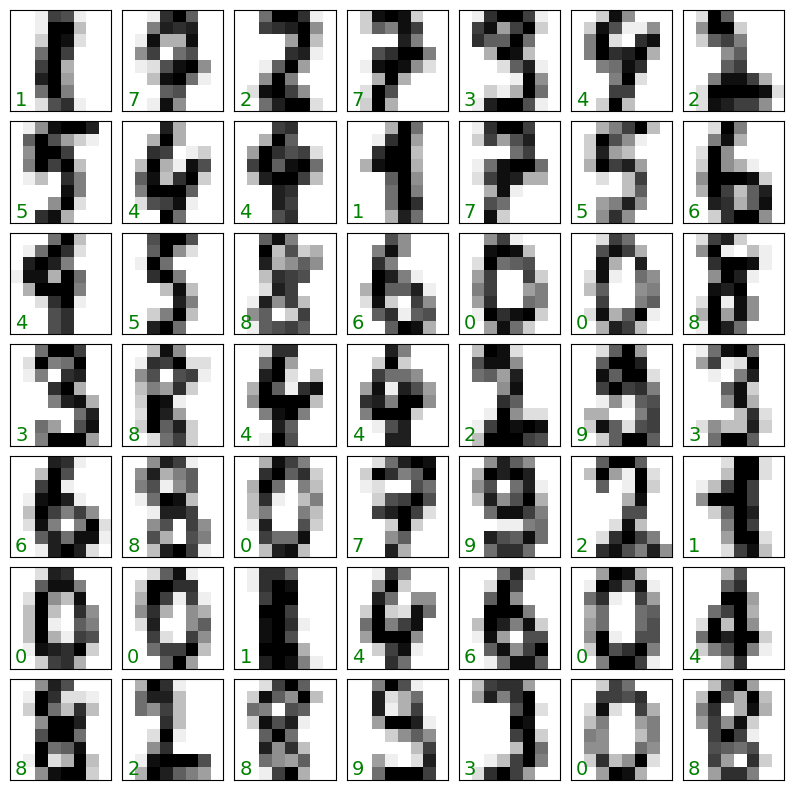

In [3]:
fig, axes = plt.subplots(7,7, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

np.random.seed(42)
mychoices = np.random.choice(digits.images.shape[0],100)

for i, ax in enumerate(axes.flat):
    ax.imshow((digits.images[mychoices[i]]), 
              cmap='binary')
    ax.text(0.05, 0.05, str(digits.target[mychoices[i]]),transform=ax.transAxes, color='green', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
print(digits.data.shape)

# The images themselves
print(digits.images[0])

# The data for use in our algorithms
print(digits.data[0])

# The labels
print(digits.target)
print(digits.target[0])

(1797, 64)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[0 1 2 ... 8 9 8]
0


### Using function defined by sklearn to plot results

In [301]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib import offsetbox

def plot_embedding(X, title):
    fig, ax = plt.subplots(figsize = (10,7))
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=30,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=1,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=2)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

### Tasks. Part 1. Unsupervised Learning: Dimensionality Reduction on Digits

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to plot points in $N=64$ dimensions! So we need to reduce the dimensionality of the space


3) Use the unsupervised dimensionality reduction technique called **[`Isomap`](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap)**. Isomap is an embedding tecnique, which tries to understand if your $N$ dimensional datapoint lives in a $M$ dimensional (with $N<M$) manifold. Have a look at the Isomap documentation and reduce the MINST dataset.  Do some plots to visualize your results 

*Note*. Isomap is very recent. It was introduced by [Tenenbaum et al (2000)](https://www.science.org/doi/10.1126/science.290.5500.2319) ---a paper that has something like $1.5\times 10^4$ [citations](https://www.science.org/doi/full/10.1126/science.290.5500.2319).


In [298]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=2, n_neighbors=30)
X_reduced = embedding.fit_transform(digits.data)
y = digits.target

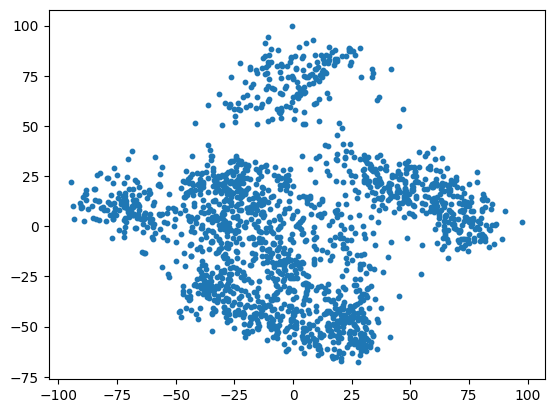

In [299]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s = 10);

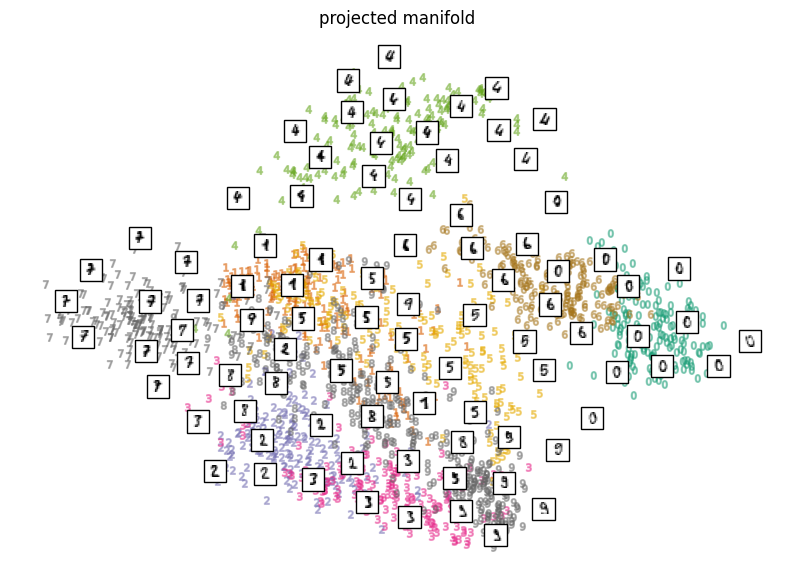

In [302]:
plot_embedding(X_reduced, 'projected manifold')

### Unsupervised learning
We find the best result with `n_neighbors=30`

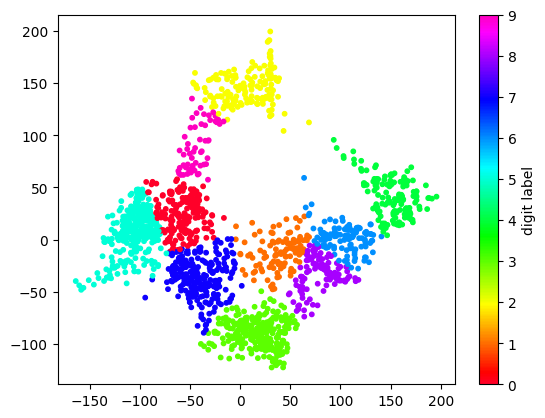

In [281]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10, n_init='auto')
k_means.fit(X_reduced)
y_pred_u = k_means.predict(X_reduced)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
            c=y_pred_u, cmap='gist_rainbow', s = 10)

plt.colorbar(label = 'digit label', ticks = range(10));

In [282]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred_u)

0.13466889259877574

### Tasks. Part 2. Supervised Learning: Classification on Digits

Now we want to classify the dataset. 

4) Split the dataset taking 80% of the images as tranining dataset and leaving the other 20% as a validation set. You need `sklearn.model_selection.train_test_split`.

5) Use a simple [`Logistic Regression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) which despite its name is a common classification algorithm. (I know, this is confusing!). Use the flag `solver='sag'`, the default solver had a bug, at least in my version.

6) Compute the accuracy (`sklearn.metrics.accuracy_score`) of your emulator. In this context, accuracy is simply the fraction of the digits that were correctly identified. Compute the accuracy on both the training and the validation set. Comment on the results.

7) The accuracy is a single number doesn't tell us ***where*** we've gone wrong. Plot the ***confusion matrix*** as we did above. What are the digits that are more challenging to identify, does it make sense?


There are many ways to improve this classifier, for example using a more sophisticated model, use cross validation, etc.  We'll get to those in the coming weeks.

In [324]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_reduced, y,test_size=0.2)

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(1437, 2) (360, 2) (1437,) (360,)


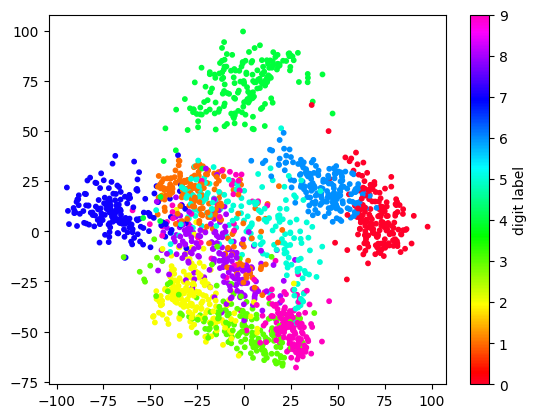

In [325]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=5000).fit(Xtrain, ytrain) #classifier
y_pred = clf.predict(Xtest)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
            c=digits.target, cmap='gist_rainbow', s = 10)

plt.colorbar(label = 'digit label', ticks = range(10));

In [326]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_pred)

0.7361111111111112

Only 10% of the digits were correctly identified! It sucks!

Edit: **Apparently changing the number of neighbors increases drastically the efficiency of the model**
Now the result makes sense! 74% accuracy

The accuracy is a single number doesn't tell us ***where*** we've gone wrong. Plot the ***confusion matrix*** as we did above. What are the digits that are more challenging to identify, does it make sense?


,0,1,2,3,4,5,6,7,8,9
0,42,0,0,0,0,0,3,0,0,0
1,0,24,0,0,0,6,0,2,4,2
2,0,0,31,6,0,0,0,0,3,0
3,0,0,7,20,0,0,0,1,3,4
4,0,0,0,0,33,0,1,2,0,0
5,0,10,0,0,0,21,1,0,1,1
6,6,0,0,0,0,0,28,0,0,0
7,0,0,0,0,0,0,0,29,3,0
8,0,3,3,1,0,3,0,2,21,2
9,0,3,0,3,0,5,0,0,4,16


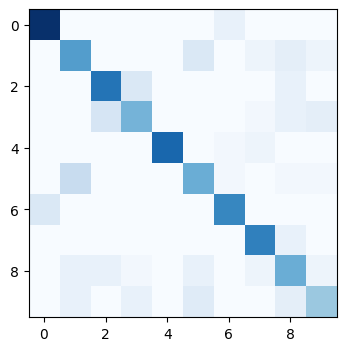

In [327]:
from sklearn.metrics import confusion_matrix
import pandas as pd

C = pd.DataFrame(confusion_matrix(ytest, y_pred), columns=[i for i in range(10)])
display(C)

fig = plt.figure(figsize=(4,4))

plt.imshow(confusion_matrix(ytest, y_pred), cmap = 'Blues', interpolation='nearest');

It seems the most confused are the 6 and the 0 and also 4 and 3, they shouldn't be so alike, this result is even more confusing to me.

## Training without dimensionality reuction
The reason of the low score is because we projected a 64 dimensional dataset in 2 dimensions, one can see that using the original data you can get a very high score

In [342]:
#UNSUPERVISED
from sklearn.cluster import KMeans

# taking 80% of the data as a training set
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, 
                                                random_state=2, train_size=0.8)

k_means = KMeans(n_clusters=10, n_init='auto')
k_means.fit(Xtrain)
y_pred_u = k_means.predict(Xtest)

accuracy_score(ytest, y_pred_u)

0.1527777777777778

In [331]:
#SUPERVISED
from sklearn.linear_model import LogisticRegression

# taking 80% of the data as a training set
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, 
                                                random_state=2, train_size=0.8)


clf = LogisticRegression(max_iter=5000).fit(Xtrain, ytrain) #classifier
y_pred = clf.predict(Xtest)

accuracy_score(ytest, y_pred)

0.9416666666666667

,0,1,2,3,4,5,6,7,8,9
0,31,0,0,0,1,0,0,0,0,0
1,0,41,0,1,0,0,0,0,1,1
2,0,0,31,0,0,0,0,0,0,0
3,0,0,0,33,0,0,0,2,1,0
4,0,0,0,0,31,0,0,0,3,1
5,0,1,0,0,1,40,0,0,0,1
6,0,1,0,0,0,0,33,0,1,0
7,0,0,0,0,0,0,0,39,0,1
8,0,0,0,0,1,0,0,0,34,1
9,0,0,0,0,0,1,0,0,1,26


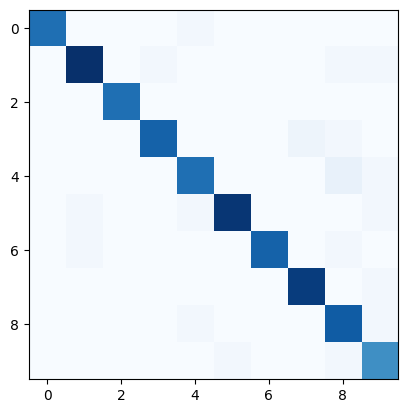

In [332]:
from sklearn.metrics import confusion_matrix
import pandas as pd

C = pd.DataFrame(confusion_matrix(ytest, y_pred), columns=[i for i in range(10)])
display(C)

plt.imshow(confusion_matrix(ytest, y_pred), cmap = 'Blues', interpolation='nearest');

# Showing the results

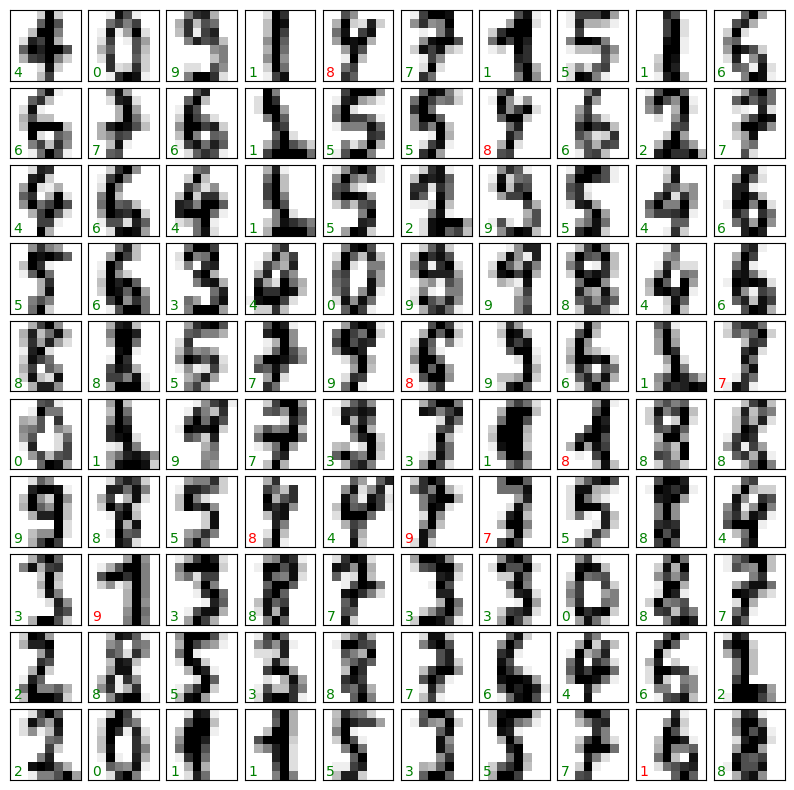

In [348]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow((Xtest[i].reshape(8, 8)), cmap='binary')
    ax.text(0.05, 0.05, str(y_pred[i]), transform=ax.transAxes, 
            color='green' if (ytest[i] == y_pred[i]) else 'red')
    ax.set_xticks([])
    ax.set_yticks([])